In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
gdp_df = pd.read_csv('gdp_analysis.csv')
X = gdp_df.loc[:,['slope', 'y_intercept', 'volatility', 'min_year', 'max_year']]
y = gdp_df.loc[:, 'got_loan']
#y = gdp_df.loc[:, 'got_mentioned']

In [3]:
gdp_df.head()

,country_name,slope,y_intercept,volatility,min_year,max_year,got_loan,got_mentioned
0,afghanistan,7.675012,-1.497918e+04,0.540344,1960.0,2020.0,0.0,0.0
1,albania,155.758189,-3.094915e+05,0.370373,1984.0,2020.0,1.0,1.0
2,algeria,76.377837,-1.498252e+05,0.568859,1960.0,2020.0,1.0,1.0
3,american samoa,228.691323,-4.494300e+05,0.597126,2002.0,2019.0,0.0,0.0
4,andorra,918.360834,-1.809247e+06,0.385188,1970.0,2019.0,0.0,0.0


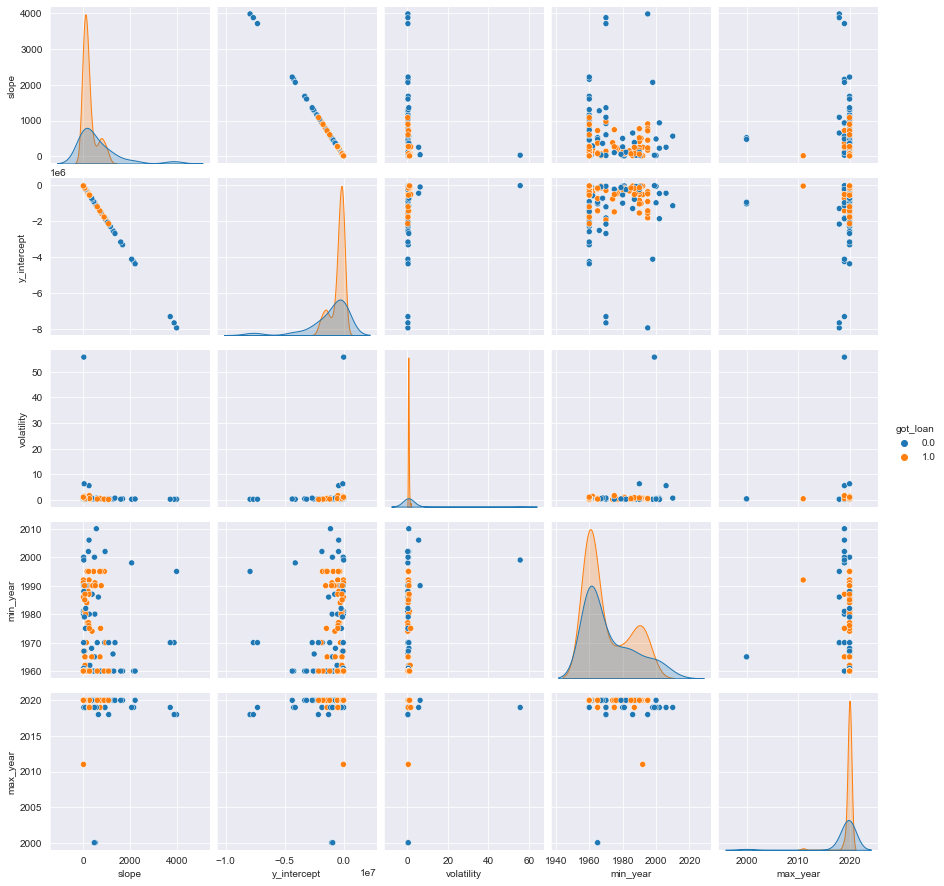

In [4]:
sns.pairplot(gdp_df, vars = ['slope', 'y_intercept', 'volatility', 'min_year', 'max_year'], hue = 'got_loan')

plt.show()

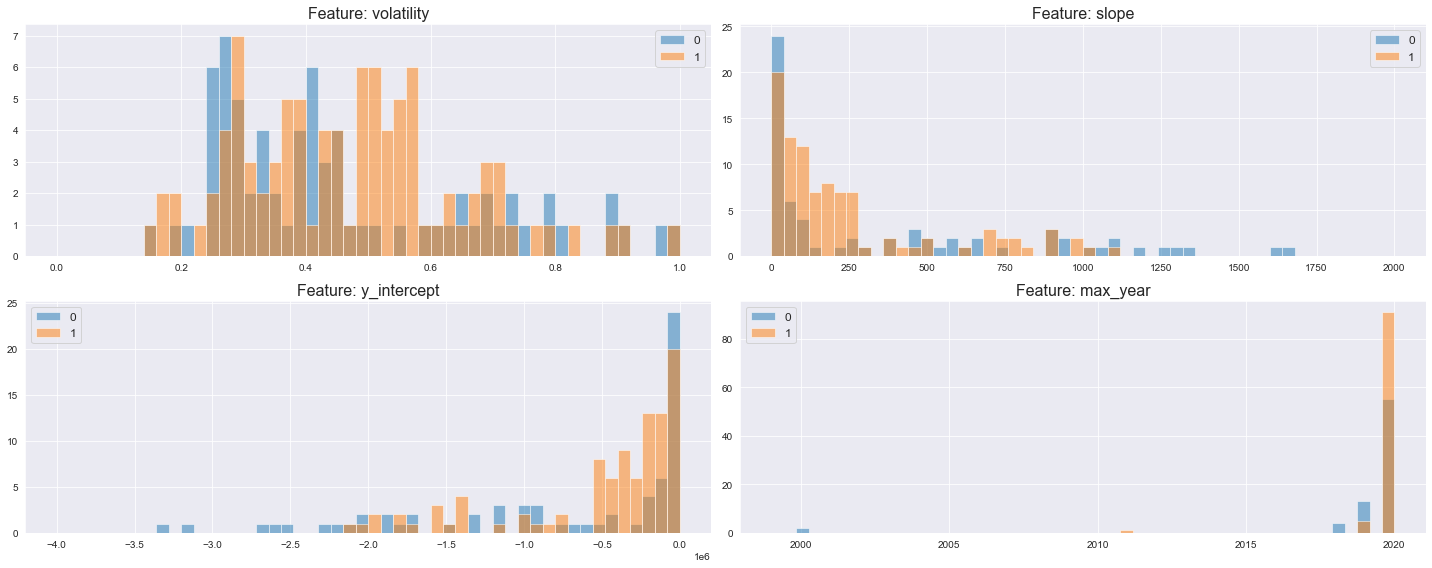

In [5]:
fig, axes = plt.subplots(2,2, figsize = (20,8))
ax = axes.ravel()

ax[0].hist(gdp_df[gdp_df.got_loan == 0.0].volatility, alpha = 0.5, range = (0,1), bins =50, label = '0')
ax[0].hist(gdp_df[gdp_df.got_loan == 1.0].volatility, alpha = 0.5,range = (0,1), bins = 50, label = '1')
ax[0].set_title('Feature: volatility', fontsize = 16)
ax[0].legend(fontsize=12)

ax[1].hist(gdp_df[gdp_df.got_loan == 0.0].slope, alpha = 0.5, range = (0,2000), bins = 50, label = '0')
ax[1].hist(gdp_df[gdp_df.got_loan == 1.0].slope, alpha = 0.5, range = (0,2000), bins = 50, label = '1')
ax[1].set_title('Feature: slope', fontsize = 16)
ax[1].legend(fontsize=12)

ax[2].hist(gdp_df[gdp_df.got_loan == 0.0].y_intercept, alpha = 0.5, range = (-4*(10**6),0), bins =50, label = '0')
ax[2].hist(gdp_df[gdp_df.got_loan == 1.0].y_intercept, alpha = 0.5,range = (-4*(10**6),0), bins = 50, label = '1')
ax[2].set_title('Feature: y_intercept', fontsize = 16)
ax[2].legend(fontsize=12)

ax[3].hist(gdp_df[gdp_df.got_loan == 0.0].max_year, alpha = 0.5, range = (1999,2020), bins = 50, label = '0')
ax[3].hist(gdp_df[gdp_df.got_loan == 1.0].max_year, alpha = 0.5, range = (1999,2020), bins = 50, label = '1')
ax[3].set_title('Feature: max_year', fontsize = 16)
ax[3].legend(fontsize=12)

fig.tight_layout()

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.base import clone

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, shuffle = True)

In [8]:
skf = StratifiedKFold(n_splits = 20)
cv = np.zeros((20,4))

rf = RandomForestClassifier(n_estimators = 60, max_depth = 4, criterion = 'gini', bootstrap = False)

i = 0
for train_index, val_index in skf.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_val = X_train.iloc[val_index]
    y_train_train = y_train.iloc[train_index]
    y_val = y_train.iloc[val_index]
    
    rf_clone = clone(rf)
    rf_clone.fit(X_train_train, y_train_train)
    
    cv[i, 0] = accuracy_score(y_val, rf_clone.predict(X_val))
    cv[i,1] = roc_auc_score(y_val, rf_clone.predict_proba(X_val)[:,1])
    
    cv[i,2] = accuracy_score(y_val, np.ones(len(y_val)))
    cv[i,3] = roc_auc_score(y_val, np.ones(len(y_val)))

    i = i + 1
    
cv_mean = np.mean(cv, axis = 0)

print('The following scores where computed agains the validation set.')
print('Mean accuracy score for Random Forest: ', np.round(cv_mean[0], 2))
print('Mean roc auc score for Random Forest: ', np.round(cv_mean[1],2))
print('Mean accuracy score for base model: ', np.round(cv_mean[2],2))
print('Mean roc auc score for base model: ', np.round(cv_mean[3],2))

The following scores where computed agains the validation set.
Mean accuracy score for Random Forest:  0.68
Mean roc auc score for Random Forest:  0.79
Mean accuracy score for base model:  0.57
Mean roc auc score for base model:  0.5


In [9]:
rf_test = RandomForestClassifier(n_estimators = 60, max_depth = 4, criterion = 'gini', bootstrap = False)
rf_test.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=4, n_estimators=60)

In [10]:
print('The following scores where computed agains the test set.')
print('Accuracy score for Random Forest: ', np.round(accuracy_score(y_test, rf_test.predict(X_test)), 2))
print('Roc auc score for Random Forest: ', np.round(roc_auc_score(y_test, rf_test.predict_proba(X_test)[:,1]), 2))

The following scores where computed agains the test set.
Accuracy score for Random Forest:  0.74
Roc auc score for Random Forest:  0.8
